
--- MODEL KARŞILAŞTIRMASI ---
               Model        MAE       RMSE        R2
1  Gradient Boosting  10.455639  13.945386  0.455953
2      Random Forest   9.987124  14.161979  0.438923
0  Linear Regression  13.481829  16.761786  0.214013


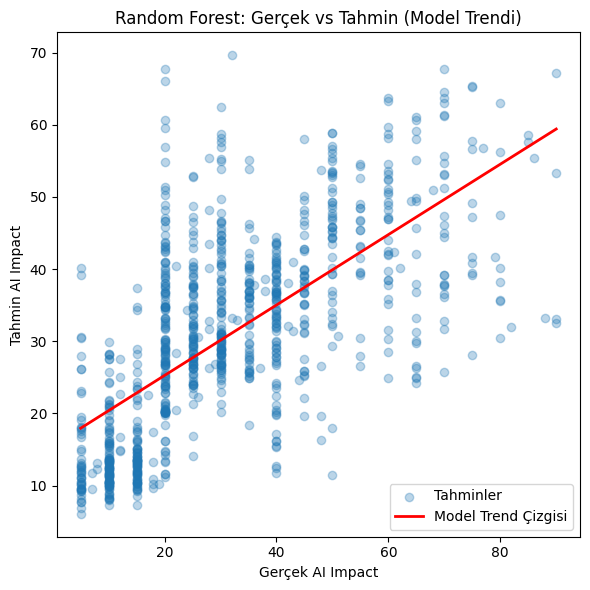

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt


df = pd.read_csv("My_Data.csv")

df["AI Impact"] = df["AI Impact"].str.replace("%", "", regex=False)
df["AI Impact"] = pd.to_numeric(df["AI Impact"], errors="coerce")

numeric_cols_all = ["AI Impact", "Tasks", "AI models", "AI_Workload_Ratio"]
df[numeric_cols_all] = df[numeric_cols_all].replace([np.inf, -np.inf], np.nan)

df["AI_Workload_Ratio"] = df["AI_Workload_Ratio"].clip(0, 1)
df = df.dropna(subset=numeric_cols_all)


y = df["AI Impact"]
X = df[["Tasks", "AI models", "AI_Workload_Ratio", "Domain"]]

numeric_features = ["Tasks", "AI models", "AI_Workload_Ratio"]
categorical_features = ["Domain"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
    ]
)


models = {
    "Linear Regression": LinearRegression(),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    )
}

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

results = []

#model karşılaştırma
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    results.append({
        "Model": name,
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2": r2_score(y_test, y_pred)
    })

results_df = pd.DataFrame(results)
print("\n--- MODEL KARŞILAŞTIRMASI ---")
print(results_df.sort_values("RMSE"))

# FiNAL MODEL = RANDOM FOREST
final_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", models["Random Forest"])
])

final_model.fit(X_train, y_train)

# classification için 
df["Predicted_AI_Impact"] = final_model.predict(X)


#görselleştirme
final_preds = final_model.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, final_preds, alpha=0.3, label="Tahminler")

m, b = np.polyfit(y_test, final_preds, 1)
x_line = np.linspace(y_test.min(), y_test.max(), 100)
y_line = m * x_line + b

plt.plot(x_line, y_line, color="red", linewidth=2, label="Model Trend Çizgisi")

plt.xlabel("Gerçek AI Impact")
plt.ylabel("Tahmin AI Impact")
plt.title("Random Forest: Gerçek vs Tahmin (Model Trendi)")
plt.legend()
plt.tight_layout()
plt.show()


df.to_csv("regression_output.csv", index=False)
